### Imports

In [1]:
import math
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split

## Exploratory Data Analysis
Below we show histograms of each feature. As you can see, the data is highly imbalanced for stroke = 0 (no stroke) and stroke = 1 (yes stroke). \
We also show a histogram, which we added to further show the imbalanced data

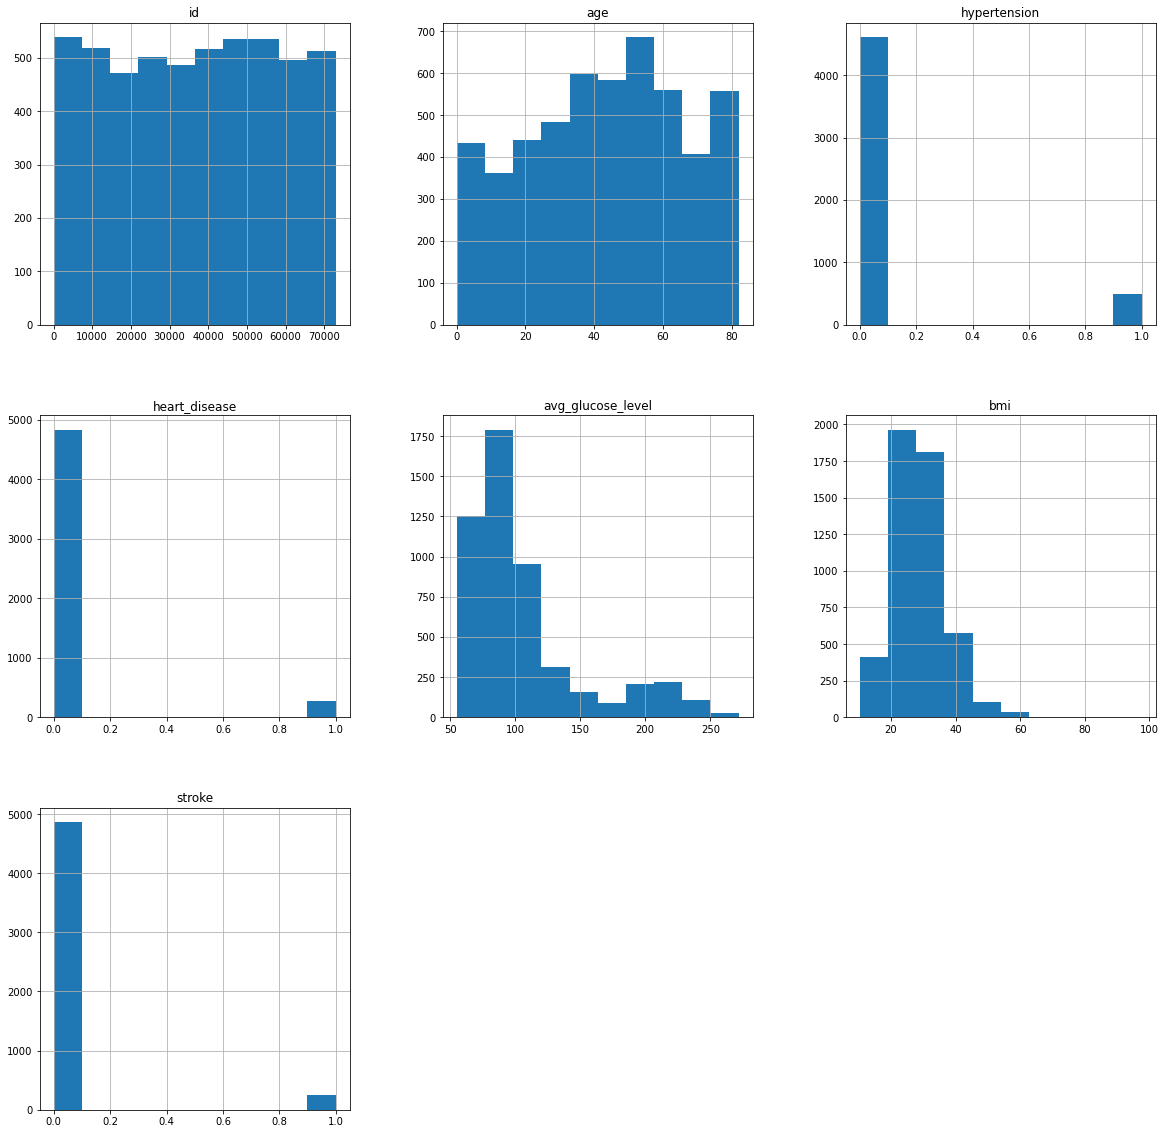

In [2]:
data = pd.read_csv('./stroke_data.csv')
data.hist(figsize=(20, 20))
plt.show()

#### Heatmap

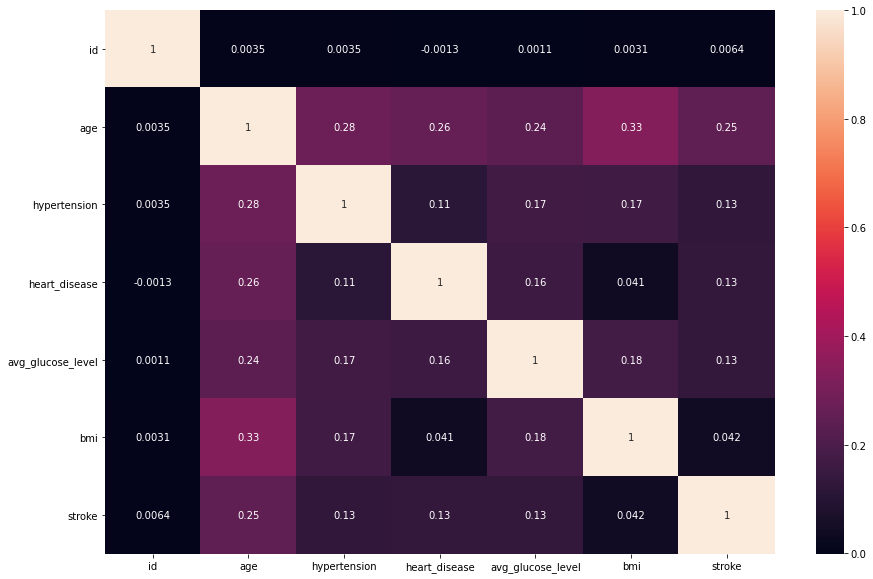

In [3]:
# heatmap - visualize correlation
plt.figure(figsize=(15, 10))
heatMap = data.corr()
sns.heatmap(heatMap, annot=True)
plt.show()

### Feature Engineering 
Clean the data to be a working dataset

In [4]:
#find and fill null values with averages (BMI has 201 null values)
avg = data['bmi'].mean()
data.bmi = (data.bmi.fillna(avg))

#### Give numerical values to categorical variables

<table>
    <thead>
        <tr>
            <th colspan=2>work_type</th>
            <th colspan=2>smoking_status</th>
            <th colspan=2>gender</th>
            <th colspan=2>Residence_type</th>
            <th colspan=2>ever_married</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>Private</td>
            <td>0</td>
            <td>formerly smoked</td>
            <td>0</td>
            <td>Male</td>
            <td>0</td>
            <td>Urban</td>
            <td>0</td>
            <td>Yes</td>
            <td>0</td>
        </tr>
        <tr>
            <td>Self-employed</td>
            <td>1</td>
            <td>never smoked</td>
            <td>1</td>
            <td>Female</td>
            <td>1</td>
            <td>Rural</td>
            <td>1</td>
            <td>No</td>
            <td>1</td>
        </tr>
        <tr>
            <td>Govt_job</td>
            <td>2</td>
            <td>smokes</td>
            <td>2</td>
        </tr>
        <tr>
            <td>children</td>
            <td>3</td>
            <td>Unknown</td>
            <td>3</td>
        </tr>
        <tr>
            <td>Never_worked</td>
            <td>4</td>
        </tr>
    </tbody>
</table>

In [5]:
data['work_type'] = data['work_type'].map(
    {'Private': 0, 'Self-employed': 1, 'Govt_job': 2, 'children': 3, 'Never_worked': 4})
data['gender'] = data['gender'].map({'Male': 0, 'Female': 1})
data['Residence_type'] = data['Residence_type'].map({'Urban': 0, 'Rural': 1})
data['smoking_status'] = data['smoking_status'].map(
    {'formerly smoked': 0, 'never smoked': 1, 'smokes': 2, 'Unknown': 3})
data['ever_married'] = data['ever_married'].map({'Yes': 0, 'No': 1})

#divide dataset into features and labels
#drop ID because it's not necessary for analysis
X = data.iloc[:, 1:-1]
y = data[['stroke']]

#replace null values again (1 in gender)
X.gender = (X.gender.fillna(1))

#### Heatmap with new Dataset

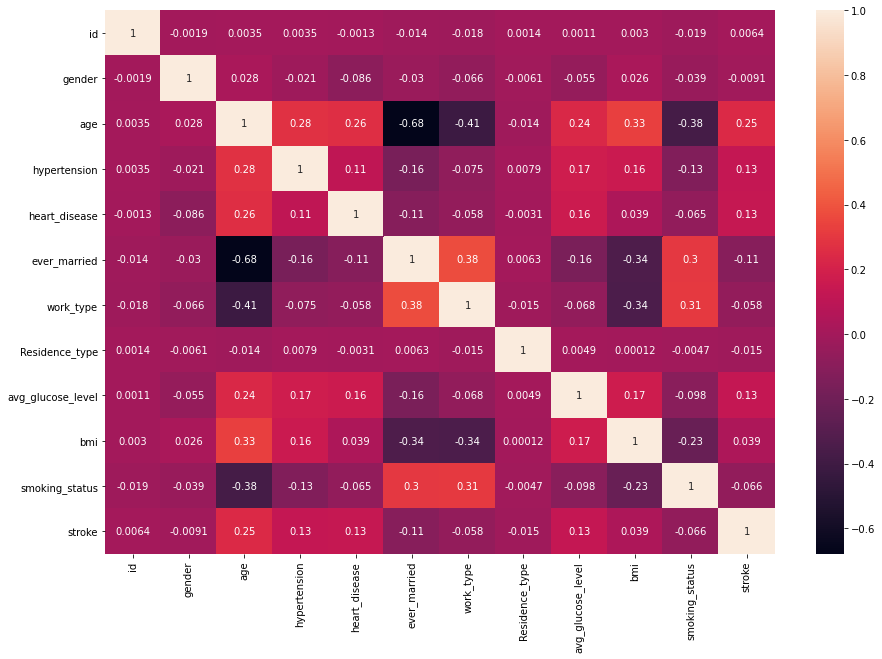

In [6]:
# heatmap - visualize correlation
plt.figure(figsize=(15, 10))
heatMap = data.corr()
sns.heatmap(heatMap, annot=True)
plt.show()

### Handle Imbalanced Data

In [7]:
smote = SMOTE()
X, y = smote.fit_resample(X, y)

### Standardize data

In [8]:
def standardize(X):
    #Standardizes the data using the mean and standard deviation
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0, ddof=1)
    s_X = (X - mean) / std

    #add bias feature
    bias = (np.ones((s_X.shape[0], 1)))
    s_X = np.append(s_X, bias, axis=1)
    return s_X

In [9]:
s_X = standardize(X)

### Functions used:

#### Sigmoid

In [10]:
def sigmoid(x, thetas):
    return 1 / (1 + math.e ** -(x @ thetas))

#### Gradient

In [11]:
def gradient(X_train, y_train, thetas):
    sig = sigmoid(X_train, thetas)
    gradient = (X_train.T @ (sig - y_train))
    return gradient

#### Batch Gradient Descent

In [35]:
def logisticBGD(X_train, y_train, X_test, y_test, n, m, kfold):
    count_num = 0
    new_cost = 0
    percent_change = 1
    thetas = np.random.uniform(-1, 1, 11).reshape(11, 1)

    #Terminate when absolute value change of loss on the data is
    #less than 2−23, or after 1500 iterations have passed (whichever occurs first).
    while percent_change > (2 ** -23):
        if count_num == 1500:
            break

        #batch gradient descent
        thetas = thetas - ((n / m) * gradient(X_train, y_train, thetas))

        #cost
        total_cost = -np.sum((1 / m) * ((y_train * np.log(sigmoid(X_train, thetas) + epsilon)) + (1 - y_train) * np.log(
            1 - sigmoid(X_train, thetas) + epsilon)))

        #percent change
        percent_change = abs((new_cost - total_cost) / total_cost)
        new_cost = total_cost

        count_num = count_num + 1

    #print("Thetas from batch gradient descent that minimize the loss function: ", thetas, "\n")
    if kfold == "kfold":
        accuracy, precision, recall, F1, TP, FP, TN, FN = prediction(y_test, X_test, thetas, kfold)
        return accuracy, precision, recall, F1, TP, FP, TN, FN
    if kfold == "no":
        prediction(y_test, X_test, thetas, kfold)


#### Stochastic Gradient Descent

In [36]:
def logisticSGD(X_train, y_train, y_test, X_test, n, m, kfold):
    stoch_X_train = X_train
    stoch_y_train = y_train
    thetas = np.random.uniform(-1, 1, 11).reshape(11, 1)
    new_cost = 1
    percent_change = 1
    count_num = 1

    #Terminate when absolute value change of loss on the data is less than 2−23, or after 1500 iterations have passed.
    while percent_change > (2 ** -23):
        if count_num == 1500:
            break

        #stochastic gradient descent
        index = np.random.permutation(stoch_X_train.shape[0])
        stoch_X_train = np.take(stoch_X_train, index, axis=0)
        stoch_y_train = np.take(stoch_y_train, index, axis=0)
        thetas = thetas - ((n / m) * gradient(stoch_X_train, stoch_y_train, thetas))

        #cost
        total_cost = -np.sum(
            (1 / m) * (stoch_y_train * np.log(sigmoid(stoch_X_train, thetas) + epsilon)) + (1 - stoch_y_train) * np.log(
                1 - sigmoid(stoch_X_train, thetas) + epsilon))

        #percent change
        percent_change = abs((new_cost - total_cost) / total_cost)
        new_cost = total_cost
        count_num = count_num + 1

    #print("Thetas from stochastic gradient descent that minimize the loss function: ", thetas, "\n")
    if kfold == "kfold":
        accuracy, precision, recall, F1, TP, FP, TN, FN = prediction(y_test, X_test, thetas, kfold)
        return accuracy, precision, recall, F1, TP, FP, TN, FN
    if kfold == "no":
        prediction(y_test, X_test, thetas, kfold)

#### K-Folds split the data

In [14]:
def cv_split(data, numfolds):
    dataset = data
    data_folds = []
    fold_size = int(dataset.shape[0] / numfolds)

    for i in range(numfolds):
        fold = []

        #add random data to the folds
        while len(fold) < fold_size:
            index = random.randrange(dataset.shape[0])
            # save data at index to fold 
            fold.append(dataset.iloc[index].values.tolist())
            # delete data line from dataset
            dataset = dataset.drop(index, axis=0)
            dataset.reset_index(drop=True, inplace=True)
        data_folds.append(np.asarray(fold))

    return data_folds

#### Cross Validation K-Folds

In [54]:
def kfold(data, model, kfold, f=5):
    data = cv_split(data, f)
    result = []
    accuracy = []
    precision = []
    recall = []
    F1 = []
    TP = []
    FP = []
    TN = []
    FN = []
    # determine training and test sets 
    for i in range(f):
        r = list(range(f))
        testi = data[i]
        r.pop(i)
        for j in r:
            if j == r[0]:
                traini = data[j]
            else:
                traini = np.concatenate((traini, data[j]), axis=0)

        k_train_x = traini[:, 0:-1]
        k_train_y = traini[:, -1]
        k_train_y = k_train_y.reshape(k_train_y.shape[0], 1)
        k_test_x = testi[:, 0:-1]
        k_test_y = pd.DataFrame(testi[:, -1])

        if model == "batch":
            accuracy1, precision1, recall1, F11, TP1, FP1, TN1, FN1 = logisticBGD(k_train_x, k_train_y, k_test_x,
                                                                                  k_test_y, n, m, kfold)
            accuracy.append(accuracy1)
            precision.append(precision1)
            recall.append(recall1)
            F1.append(F11)
            TP.append(TP1)
            FP.append(FP1)
            TN.append(TN1)
            FN.append(FN1)
        if model == "stochastic":
            accuracy1, precision1, recall1, F11, TP1, FP1, TN1, FN1 = logisticSGD(k_train_x, k_train_y, k_test_y,
                                                                                  k_test_x, n, m, kfold)
            accuracy.append(accuracy1)
            precision.append(precision1)
            recall.append(recall1)
            F1.append(F11)
            TP.append(TP1)
            FP.append(FP1)
            TN.append(TN1)
            FN.append(FN1)
    print("Accuracies: ", np.array(accuracy) * 100)
    print("Precisions: ", np.array(precision) * 100)
    print("Recalls: ", np.array(recall) * 100)
    print("F-measures: ", np.array(F1) * 100)
    print("TP: ", TP, "\nFP: ", FP, "\nTN: ", TN, "\nFN: ", FN)

#### Predict

In [47]:
def prediction(y_test, X_test, thetas, kfold):
    size_test = y_test.shape[0]
    predictions = np.zeros(size_test)
    TP = FP = TN = FN = accuracy = 0

    #find probability for 1 and 0
    for a in range(size_test):
        p_1 = 1 / (1 + math.e ** -(X_test[a] @ thetas))
        p_0 = 1 - p_1
        if p_1 > p_0:
            predictions[a] = 1
        else:
            predictions[a] = 0

    #find TP, FP, TN, FN
    for a in range(size_test):
        if predictions[a] == 1:
            if predictions[a] == y_test.iloc[a][0]:
                TP = TP + 1
                accuracy = accuracy + 1
            else:
                FP = FP + 1
        else:
            if predictions[a] == y_test.iloc[a][0]:
                TN = TN + 1
                accuracy = accuracy + 1
            else:
                FN = FN + 1

    #precision, recall, f measure, accuracy
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F1 = (2 * precision * recall) / (precision + recall)
    accuracy = accuracy / size_test

    if kfold == "kfold":
        return accuracy, precision, recall, F1, TP, FP, TN, FN

    else:
        print("Accuracy: ", accuracy * 100)
        print("Precision: ", precision * 100)
        print("Recall: ", recall * 100)
        print("F-measure: ", F1 * 100)
        print("TP: ", TP, "; FP: ", FP, "; TN: ", TN, "; FN: ", FN)

## Results Without K-Folds

#### Split the dataset into train and test

In [17]:
X_train, X_test, y_train, y_test = train_test_split(s_X, y, test_size=0.33, random_state=0)
y_train = y_train.values

#### Common Variables

In [18]:
random.seed(0)
n = 0.01  #learning rate
count = pd.DataFrame()
percent_change = 1
count_num = 1
cost = 1
m = X_train.shape[0]
#y_train = y_train.to_numpy()
epsilon = 1e-5

#### Logistic Regression using Batch Gradient Descent

In [19]:
logisticBGD(X_train, y_train, X_test, y_test, n, m, "no")

Accuracy:  81.11561234029293
Precision:  78.09894385769873
Recall:  86.88930117501546
F-measure:  82.25995316159252
TP:  1405 ; FP:  394 ; TN:  1198 ; FN:  212


#### Logistic Regression using Stochastic Gradient Descent

In [20]:
logisticSGD(X_train, y_train, y_test, X_test, n, m, "no")

Accuracy:  81.52072296665628
Precision:  78.10098792535675
Recall:  88.00247371675944
F-measure:  82.75661529514393
TP:  1423 ; FP:  399 ; TN:  1193 ; FN:  194


#### Built-in function

Accuracy:  81.738859457775
Precision:  79.98836532867946
Recall:  85.03401360544217
F-measure:  82.43405275779376


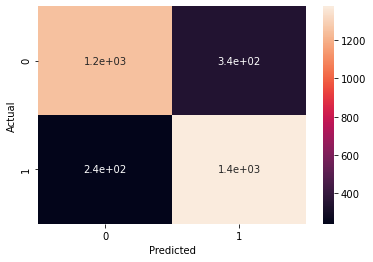

In [25]:
X_train, X_test, y_train, y_test = train_test_split(s_X, y, test_size=0.33, random_state=0)
y_train = y_train.values.ravel()

#y_train = y_train.ravel()
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)
y_pred = logistic_regression.predict(X_test)
y_test = y_test.values
y_test = y_test.reshape(3209, )
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred) * 100)
print('Precision: ', metrics.precision_score(y_test, y_pred, zero_division=0) * 100)
print('Recall: ', metrics.recall_score(y_test, y_pred) * 100)
print('F-measure: ', metrics.f1_score(y_test, y_pred, zero_division=0) * 100)

plt.show()

In [ ]:
SGDClassifier(loss='log')

## Results With K-Folds

In [44]:
data = np.append(s_X, y, axis=1)
data = pd.DataFrame(data)

#### Logistic Regression using Batch Gradient Descent, k-folds = 5

In [56]:
kfold(data, "batch", "kfold", 10)

Accuracies:  [79.42386831 79.9382716  81.06995885 82.81893004 79.83539095 81.27572016
 81.79012346 82.61316872 78.60082305 81.99588477]
Precisions:  [77.31397459 76.68593449 76.12208259 80.11257036 78.47619048 77.99642218
 79.73977695 77.56183746 73.58834244 79.58412098]
Recalls:  [85.02994012 84.3220339  89.26315789 87.5        83.23232323 88.08080808
 86.31790744 91.26819127 86.50963597 86.2704918 ]
F-measures:  [80.98859316 80.32290616 82.17054264 83.64348678 80.78431373 82.73244782
 82.89855072 83.85864374 79.52755906 82.79252704]
TP:  [426, 398, 424, 427, 412, 436, 429, 439, 404, 421] 
FP:  [125, 121, 133, 106, 113, 123, 109, 127, 145, 108] 
TN:  [346, 379, 364, 378, 364, 354, 366, 364, 360, 376] 
FN:  [75, 74, 51, 61, 83, 59, 68, 42, 63, 67]


#### Logistic Regression using Stochastic Gradient Descent, k-folds = 5

In [57]:
kfold(data, "stochastic", "kfold", 10)

Accuracies:  [82.61316872 80.4526749  82.51028807 80.76131687 83.43621399 80.14403292
 80.76131687 82.09876543 80.65843621 80.96707819]
Precisions:  [79.81818182 75.84369449 80.03731343 75.64102564 82.08955224 77.87934186
 77.02205882 77.37881508 78.32422587 75.65055762]
Recalls:  [88.32997988 88.77338877 87.19512195 88.43683084 87.12871287 85.54216867
 87.11018711 89.97912317 86.17234469 88.28633406]
F-measures:  [83.85864374 81.80076628 83.46303502 81.53998026 84.53410183 81.53110048
 81.75609756 83.2046332  82.0610687  81.48148148]
TP:  [439, 427, 429, 413, 440, 426, 419, 431, 430, 407] 
FP:  [111, 136, 107, 133, 96, 121, 125, 126, 119, 131] 
TN:  [364, 355, 373, 372, 371, 353, 366, 367, 354, 380] 
FN:  [58, 54, 63, 54, 65, 72, 62, 48, 69, 54]
